In [2]:
import scipy.io
import os
from scipy.interpolate import interp1d
from scipy import signal
import numpy as np
import pylab as plt
import pandas as pd
import xarray as xr
# from isqg import *
from numpy import *
from pylab import *
import gsw
from xrft import detrend
import xrft
import imageio
from IPython.display import Video
from matplotlib.colorbar import ColorbarBase
from scipy.signal import convolve2d
from geopy.distance import geodesic


In [3]:
def determine_window_sizes(lat, lon, desired_resolution_km):
    numlines, numpixels = lat.shape
    
    # Calculate distances between adjacent points
    distances_alongtrack = [
        geodesic((lat[i, 0], lon[i, 0]), (lat[i+1, 0], lon[i+1, 0])).km
        for i in range(numlines - 1)
    ]
    distances_crosstrack = [
        geodesic((lat[0, j], lon[0, j]), (lat[0, j+1], lon[0, j+1])).km
        for j in range(numpixels - 1)
    ]
    
    # Average distance between points
    avg_distance_alongtrack = np.mean(distances_alongtrack)
    avg_distance_crosstrack = np.mean(distances_crosstrack)
    
    # Convert the desired resolution into the number of grid points
    dy = int(desired_resolution_km / avg_distance_alongtrack)
    dx = int(desired_resolution_km / avg_distance_crosstrack)
    
    return dy, dx

def apply_hanning(data, lat, lon, desired_resolution_km):
    dy, dx = determine_window_sizes(lat, lon, desired_resolution_km)
    
    window_alongtrack = np.hanning(dy)
    window_crosstrack = np.hanning(dx)
    window = window_alongtrack[:, None] * window_crosstrack[None, :]  # Create a 2D window
    window /= window.sum()  # Normalize the window to preserve data amplitude

    # Pad data to minimize edge effects
    pad_width_alongtrack = dy // 2
    pad_width_crosstrack = dx // 2
    data_padded = np.pad(data, ((pad_width_alongtrack, pad_width_alongtrack),
                                (pad_width_crosstrack, pad_width_crosstrack)), mode='reflect')

    # Handle NaNs by treating them as zero (influence can be limited by normalizing the window)
    nan_mask = np.isnan(data_padded)
    data_padded[nan_mask] = 0
    filtered_data = convolve2d(data_padded, window, mode='valid', boundary='fill', fillvalue=0)

    # Correct the NaN influence by reapplying the nan_mask
    nan_mask = nan_mask.astype(float)
    normalization = convolve2d(1 - nan_mask, window, mode='valid', boundary='fill', fillvalue=0)
    filtered_data /= normalization
    nan_result_mask = normalization == 0
    filtered_data[nan_result_mask] = np.nan

    return filtered_data

In [4]:
# from scipy.signal import convolve2d
# def apply_hanning(data, size_alongtrack, size_crosstrack):
#     window_alongtrack = np.hanning(size_alongtrack)
#     window_crosstrack = np.hanning(size_crosstrack)
#     window = window_alongtrack[:, None] * window_crosstrack[None, :]  # Create a 2D window
#     window /= window.sum()  # Normalize the window to preserve data amplitude

#     # Pad data to minimize edge effects
#     pad_width_alongtrack = size_alongtrack // 2
#     pad_width_crosstrack = size_crosstrack // 2
#     data_padded = np.pad(data, ((pad_width_alongtrack, pad_width_alongtrack),
#                                 (pad_width_crosstrack, pad_width_crosstrack)), mode='reflect')

#     # Handle NaNs by treating them as zero (influence can be limited by normalizing the window)
#     nan_mask = np.isnan(data_padded)
#     data_padded[nan_mask] = 0
#     filtered_data = convolve2d(data_padded, window, mode='valid', boundary='fill', fillvalue=0)

#     # Correct the NaN influence by reapplying the nan_mask
#     nan_mask = nan_mask.astype(float)
#     normalization = convolve2d(1 - nan_mask, window, mode='valid', boundary='fill', fillvalue=0)
#     filtered_data /= normalization
#     nan_result_mask = normalization == 0
#     filtered_data[nan_result_mask] = np.nan

#     return filtered_data

In [5]:
def calculate_bearing(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Difference in the coordinates
    dlon = lon2 - lon1

    # Primary calculation
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(dlon))

    # Bearing converted from radians to degrees
    initial_bearing = np.arctan2(x, y)
    initial_bearing = np.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

In [6]:
def compute_along_track_directions(latitudes, longitudes):
    bearings = []
    for i in range(len(latitudes) - 1):
        bearing = calculate_bearing(latitudes[i], longitudes[i], latitudes[i + 1], longitudes[i + 1])
        bearings.append(bearing)
    return bearings

def compute_average_bearing(bearings):
    # Convert bearings to radians for circular mean calculation
    radian_bearings = np.radians(bearings)
    average_bearing_radians = np.arctan2(np.mean(np.sin(radian_bearings)), np.mean(np.cos(radian_bearings)))
    average_bearing_degrees = np.degrees(average_bearing_radians) % 360
    return average_bearing_degrees


In [7]:
def rotate_coordinates(u_local, v_local, theta_deg):
    theta_rad = np.radians(theta_deg)
    u_geo = u_local * np.cos(theta_rad) - v_local * np.sin(theta_rad)  # Ensure the correct rotation matrix
    v_geo = u_local * np.sin(theta_rad) + v_local * np.cos(theta_rad)
    return u_geo, v_geo

def compute_geostrophic_velocities_through_time(time, lat, lon, ssh):
    """
    Compute geostrophic velocities from SSH data and project them to northward and eastward components.
    
    Parameters:
    lat (numpy.ndarray): Latitude values, 2D array (num_lines, num_pixels).
    lon (numpy.ndarray): Longitude values, 2D array (num_lines, num_pixels).
    ssh (numpy.ndarray): Sea surface height values, either 2D array (num_lines, num_pixels) or 3D array (time, num_lines, num_pixels).
    
    Returns:
    xarray.Dataset: Dataset enriched with geostrophic velocity components 'u_g', 'v_g', 'v_n' (northward), and 'v_e' (eastward).
    """
    # Ensure input arrays have the correct dimensions
    assert lat.shape == lon.shape, "Latitude and longitude arrays must have the same shape."
    
    if ssh.ndim == 2:
        ssh = np.expand_dims(ssh, axis=0)  # Add time dimension if only a single time slice is provided
    
    assert ssh.shape[1:] == lat.shape, "SSH spatial dimensions must match latitude and longitude dimensions."

    # Constants
    g = 9.81  # Acceleration due to gravity in m/s^2
    omega = 7.2921e-5  # Earth's rotation rate in rad/s
    earth_radius = 6371000  # Earth radius in meters

    # Initialize arrays for gradients and velocities
    grad_ssh_x = np.empty_like(ssh)
    grad_ssh_y = np.empty_like(ssh)
    u_g = np.empty_like(ssh)
    v_g = np.empty_like(ssh)
    v_n = np.empty_like(ssh)
    v_e = np.empty_like(ssh)

    # Calculate the angle theta for rotation
    dlon = np.gradient(lon, axis=1)
    dlat = np.gradient(lat, axis=0)
    theta_deg = np.degrees(np.arctan2(dlat, dlon))  # Ensure theta_deg is in degrees

    # Loop through each time step
    for t in range(ssh.shape[0]):
        # Create xarray.Dataset for the current time step
        ds = xr.Dataset(
            {
                'SSH': (['num_lines', 'num_pixels'], ssh[t])
            },
            coords={
                'latitude': (['num_lines', 'num_pixels'], lat),
                'longitude': (['num_lines', 'num_pixels'], lon)
            }
        )

        # Calculate the Coriolis parameter
        ds['f'] = 2 * omega * np.sin(np.deg2rad(ds.latitude))

        # Calculate spatial deltas in meters for longitude and latitude
        # Longitude
        longitude_diff = np.diff(ds.longitude, axis=1)
        longitude_diff[longitude_diff > 180] -= 360  # Correct for dateline jump
        longitude_diff[longitude_diff < -180] += 360
        longitude_diff_extended = np.pad(longitude_diff, ((0, 0), (0, 1)), mode='edge')
        dx = xr.DataArray(
            (earth_radius * np.cos(np.deg2rad(ds.latitude)) * (np.pi / 180)) * longitude_diff_extended,
            dims=('num_lines', 'num_pixels'),
            coords={'num_lines': ds.num_lines, 'num_pixels': ds.num_pixels}
        )

        # Latitude
        latitude_diff = np.diff(ds.latitude, axis=0)
        latitude_diff_extended = np.pad(latitude_diff, ((0, 1), (0, 0)), mode='edge')
        dy = xr.DataArray(
            (earth_radius * np.pi / 180) * latitude_diff_extended,
            dims=('num_lines', 'num_pixels'),
            coords={'num_lines': ds.num_lines, 'num_pixels': ds.num_pixels}
        )

        # Compute gradients of SSH
        ds['grad_ssh_x'] = xr.DataArray(np.gradient(ds.SSH, axis=1) / dx, dims=('num_lines', 'num_pixels'), coords=ds.SSH.coords)
        ds['grad_ssh_y'] = xr.DataArray(np.gradient(ds.SSH, axis=0) / dy, dims=('num_lines', 'num_pixels'), coords=ds.SSH.coords)

        # Calculate geostrophic velocities
        u_g[t] = -g / ds['f'] * ds['grad_ssh_y']
        v_g[t] = g / ds['f'] * ds['grad_ssh_x']

        # Rotate velocities to northward and eastward components
        v_e[t], v_n[t] = rotate_coordinates(u_g[t], v_g[t], theta_deg)  # Swap order for correct assignment

    # Create the final xarray.Dataset with all time steps
    ds_final = xr.Dataset(
        {
            'SSH': (['time', 'num_lines', 'num_pixels'], ssh),
            'u_g': (['time', 'num_lines', 'num_pixels'], u_g),
            'v_g': (['time', 'num_lines', 'num_pixels'], v_g),
            'v_n': (['time', 'num_lines', 'num_pixels'], -v_n),
            'v_e': (['time', 'num_lines', 'num_pixels'], -v_e),
            'grad_ssh_x': (['time', 'num_lines', 'num_pixels'], grad_ssh_x),
            'grad_ssh_y': (['time', 'num_lines', 'num_pixels'], grad_ssh_y)
        },
        coords={
            'latitude': (['num_lines', 'num_pixels'], lat),
            'longitude': (['num_lines', 'num_pixels'], lon),
            'time': (['time'], time)
        }
    )

    return ds_final

In [8]:
# def rotate_coordinates(u_local, v_local, theta_deg):
#     theta_rad = np.radians(theta_deg)
#     u_geo = u_local * np.cos(theta_rad) - v_local * np.sin(theta_rad)
#     v_geo = u_local * np.sin(theta_rad) + v_local * np.cos(theta_rad)
#     return u_geo, v_geo
def rotate_coordinates(u_local, v_local, theta_deg):
    theta_rad = np.radians(theta_deg)
    u_geo = u_local * np.cos(theta_rad) + v_local * np.sin(theta_rad)  # Adjusted signs
    v_geo = u_local * np.sin(theta_rad) + v_local * np.cos(theta_rad)  # Adjusted signs
    return u_geo, v_geo

def compute_geostrophic_velocities_through_time(time, lat, lon, ssh):
    """
    Compute geostrophic velocities from SSH data and project them to northward and eastward components.
    
    Parameters:
    lat (numpy.ndarray): Latitude values, 2D array (num_lines, num_pixels).
    lon (numpy.ndarray): Longitude values, 2D array (num_lines, num_pixels).
    ssh (numpy.ndarray): Sea surface height values, either 2D array (num_lines, num_pixels) or 3D array (time, num_lines, num_pixels).
    
    Returns:
    xarray.Dataset: Dataset enriched with geostrophic velocity components 'u_g', 'v_g', 'v_n' (northward), and 'v_e' (eastward).
    """
    # Ensure input arrays have the correct dimensions
    assert lat.shape == lon.shape, "Latitude and longitude arrays must have the same shape."
    
    if ssh.ndim == 2:
        ssh = np.expand_dims(ssh, axis=0)  # Add time dimension if only a single time slice is provided
    
    assert ssh.shape[1:] == lat.shape, "SSH spatial dimensions must match latitude and longitude dimensions."

    # Constants
    g = 9.81  # Acceleration due to gravity in m/s^2
    omega = 7.2921e-5  # Earth's rotation rate in rad/s
    earth_radius = 6371000  # Earth radius in meters

    # Initialize arrays for gradients and velocities
    grad_ssh_x = np.empty_like(ssh)
    grad_ssh_y = np.empty_like(ssh)
    u_g = np.empty_like(ssh)
    v_g = np.empty_like(ssh)
    v_n = np.empty_like(ssh)
    v_e = np.empty_like(ssh)

    # Calculate the angle theta for rotation
    dlon = np.gradient(lon, axis=1)
    dlat = np.gradient(lat, axis=0)
    theta_deg = np.arctan2(dlat, dlon) * 180 / np.pi

    # Loop through each time step
    for t in range(ssh.shape[0]):
        # Create xarray.Dataset for the current time step
        ds = xr.Dataset(
            {
                'SSH': (['num_lines', 'num_pixels'], ssh[t])
            },
            coords={
                'latitude': (['num_lines', 'num_pixels'], lat),
                'longitude': (['num_lines', 'num_pixels'], lon)
            }
        )

        # Calculate the Coriolis parameter
        ds['f'] = 2 * omega * np.sin(np.deg2rad(ds.latitude))

        # Calculate spatial deltas in meters for longitude and latitude
        # Longitude
        longitude_diff = np.diff(ds.longitude, axis=1)
        longitude_diff[longitude_diff > 180] -= 360  # Correct for dateline jump
        longitude_diff[longitude_diff < -180] += 360
        longitude_diff_extended = np.pad(longitude_diff, ((0, 0), (0, 1)), mode='edge')
        dx = xr.DataArray(
            (earth_radius * np.cos(np.deg2rad(ds.latitude)) * (np.pi / 180)) * longitude_diff_extended,
            dims=('num_lines', 'num_pixels'),
            coords={'num_lines': ds.num_lines, 'num_pixels': ds.num_pixels}
        )

        # Latitude
        latitude_diff = np.diff(ds.latitude, axis=0)
        latitude_diff_extended = np.pad(latitude_diff, ((0, 1), (0, 0)), mode='edge')
        dy = xr.DataArray(
            (earth_radius * np.pi / 180) * latitude_diff_extended,
            dims=('num_lines', 'num_pixels'),
            coords={'num_lines': ds.num_lines, 'num_pixels': ds.num_pixels}
        )

        # Compute gradients of SSH
        ds['grad_ssh_x'] = xr.DataArray(np.gradient(ds.SSH, axis=1) / dx, dims=('num_lines', 'num_pixels'), coords=ds.SSH.coords)
        ds['grad_ssh_y'] = xr.DataArray(np.gradient(ds.SSH, axis=0) / dy, dims=('num_lines', 'num_pixels'), coords=ds.SSH.coords)

        # Calculate geostrophic velocities
        u_g[t] = -g / ds['f'] * ds['grad_ssh_y']
        v_g[t] = g / ds['f'] * ds['grad_ssh_x']

        # Rotate velocities to northward and eastward components
        v_n[t], v_e[t] = rotate_coordinates(u_g[t], v_g[t], theta_deg)

    # Create the final xarray.Dataset with all time steps
    ds_final = xr.Dataset(
        {
            'SSH': (['time', 'num_lines', 'num_pixels'], ssh),
            'u_g': (['time', 'num_lines', 'num_pixels'], u_g),
            'v_g': (['time', 'num_lines', 'num_pixels'], v_g),
            'v_n': (['time', 'num_lines', 'num_pixels'], v_n),
            'v_e': (['time', 'num_lines', 'num_pixels'], v_e),
            'grad_ssh_x': (['time', 'num_lines', 'num_pixels'], grad_ssh_x),
            'grad_ssh_y': (['time', 'num_lines', 'num_pixels'], grad_ssh_y)
        },
        coords={
            'latitude': (['num_lines', 'num_pixels'], lat),
            'longitude': (['num_lines', 'num_pixels'], lon),
            'time': (['time'], time)
        }
    )

    return ds_final


In [9]:
def list_nc_files_with_pattern(directory, track):
    files = []
    for filename in os.listdir(directory):
        if filename.endswith('.nc') and track in filename:
            files.append(filename)
    return sorted(files)

In [27]:
path = '/mnt/flow/swot/Matt_Analysis/CNES_L3_CalVal/version_V1_0/'
nc_swot_026 = xr.open_dataset(path+'SUBSET_SWOT_PASS_013_OVER_CALVAL_REGION_V1.0.nc')#xr.open_dataset(path+'SUBSET_SWOT_PASS_026_OVER_CALVAL_REGION_V1.0.nc')
nc_swot_013 = xr.open_dataset(path+'SUBSET_SWOT_PASS_013_OVER_CALVAL_REGION_V1.0.nc')

nc_avi_026 = xr.open_dataset(path+'SUBSET_AVISO_PASS_013_OVER_CALVAL_REGION_V1.0.nc')#xr.open_dataset(path+'SUBSET_AVISO_PASS_026_OVER_CALVAL_REGION_V1.0.nc')
nc_avi_013 = xr.open_dataset(path+'SUBSET_AVISO_PASS_013_OVER_CALVAL_REGION_V1.0.nc')

In [28]:
time_026 = nc_swot_026.time.values
lon_026 = nc_swot_026.lon.values
lat_026 = nc_swot_026.lat.values

time_013 = nc_swot_013.time.values
lon_013 = nc_swot_013.lon.values
lat_013 = nc_swot_013.lat.values

ssh_swot_026 = nc_swot_026.__xarray_dataarray_variable__.values
ssh_swot_013 = nc_swot_013.__xarray_dataarray_variable__.values

ssh_avi_026 = nc_avi_026.sla.values
ssh_avi_013 = nc_avi_013.sla.values

In [29]:
time_013[80]

numpy.datetime64('2023-06-23T19:15:59.661052416')

In [30]:
time_026[81]

numpy.datetime64('2023-06-24T19:06:37.596364800')

In [31]:
ssh_avi_026 = np.where(np.isnan(ssh_swot_026), np.nan, ssh_avi_026)
ssh_avi_013 = np.where(np.isnan(ssh_swot_013), np.nan, ssh_avi_013 )

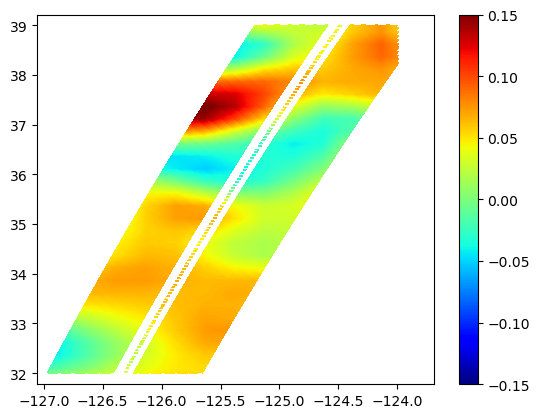

In [32]:
plt.pcolor(lon_026, lat_026,ssh_avi_026[81,:,:], vmin=-.15, vmax=.15,cmap='jet')
plt.pcolor(lon_013, lat_013,ssh_avi_013[80,:,:], vmin=-.15, vmax=.15,cmap='jet')
plt.colorbar()

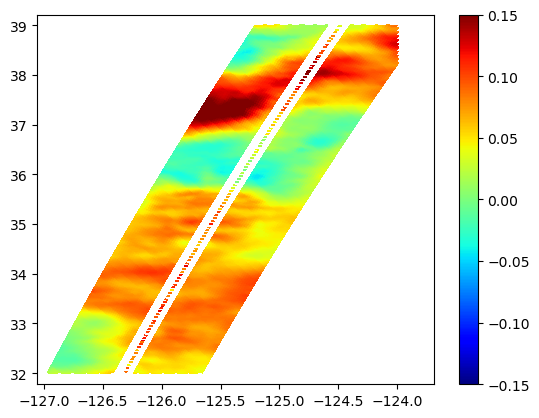

In [33]:
plt.pcolor(lon_026, lat_026,ssh_swot_026[81,:,:], vmin=-.15, vmax=.15,cmap='jet')
plt.pcolor(lon_013, lat_013,ssh_swot_013[80,:,:], vmin=-.15, vmax=.15,cmap='jet')

plt.colorbar()

In [34]:
np.diff(lat_026).min()

-0.0041750000000035925

In [35]:
# compute the geostrophy velocities though time
da_026 = compute_geostrophic_velocities_through_time(time_026,lat_026, lon_026, ssh_swot_026)
# Calculate total velocity
da_026["ut_g"] = np.sqrt(da_026["u_g"] ** 2 + da_026["v_g"] ** 2)

In [36]:
# Create a mask where ssh_swot is NaN
nan_mask = np.isnan(da_026.ut_g.values)

# Calculate total velocity
nc_avi_026["utgosa"] = np.sqrt(nc_avi_026["ugosa"] ** 2 + nc_avi_026["vgosa"] ** 2)

# Apply this mask to the entire dataset of aviso
nc_avi_026 = nc_avi_026.where(~nan_mask, other=np.nan)

In [ ]:
# Loop through each time step and plot

# Common plot parameters
params_ut = {
    'vmin': 0,
    'vmax': 0.4,
    'x': 'longitude',
    'y': 'latitude',
    'xlim': (-127, -124),
    'ylim': (32, 39),
    'cmap': 'jet',
    'add_colorbar': False  # Disable individual colorbars
}

params_uv = {
    'vmin': -0.25,
    'vmax': 0.25,
    'x': 'longitude',
    'y': 'latitude',
    'xlim': (-127, -124),
    'ylim': (32, 39),
    'cmap': 'seismic_r',
    'add_colorbar': False  # Disable individual colorbars
}

# cmap = plt.cm.RdBu_r
xtick = ['-127','-126.5','-126', '-125.5','-125', '-124.5', '-124']
list1=[-127, -126.5, -126, -125.5,-125, -124.5, -124]
ytick = ['32','33','34','35','36','37','38','39']
list2=[32, 33, 34, 35, 36, 37,38, 39]
tick_uv = [-.25, -.2,-.15,-.1,-.05,0,.05,.1,.15, .2,.25]
tick_ut = [0,.05,.1,.15, .2,.25,.3,.35,.4]
cb = 'm.s$^{-1}$'
font = 25; n=8
images_directory = '/home/tchonang/calval/figure/images/pass_013/swot/'
# Set the figure resolution (optional)
dpi = 300  # Set the desired dots per inch (DPI)
label_fontsize = 14
tick_fontsize = 12
title_fontsize = 16

for it,t in enumerate(da_026.time):
    fig, axes = plt.subplots(1, 3, figsize=(18, 7), sharey=True)
    
    # Zonal velocity
    u_plot = da_026.u_g.sel(time=t).plot(ax=axes[0], **params_uv)
    axes[0].set_title('Zonal Velocity')
    axes[0].set_xticks(list1, xtick)
    axes[0].set_yticks(list2)
    axes[0].set_xticklabels(xtick,fontsize=label_fontsize)
    axes[0].set_yticklabels(ytick,fontsize=label_fontsize)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('')
    
    # Meridional velocity
    u_plot = da_026.v_g.sel(time=t).plot(ax=axes[1], **params_uv)
    axes[1].set_title('Meridional Velocity')
    axes[1].set_xticks(list1)
    axes[1].set_yticks(list2)
    axes[1].set_xticklabels(xtick,fontsize=label_fontsize)
    axes[1].set_yticklabels(ytick,fontsize=label_fontsize)
    axes[1].set_xlabel('')
    axes[1].set_ylabel('')
    
    # Total velocity
    total_plot = da_026.ut_g.sel(time=t).plot(ax=axes[2], **params_ut)
    axes[2].set_title('Total Velocity')
    axes[2].set_xticks(list1)
    axes[2].set_yticks(list2)
    axes[2].set_xticklabels(xtick,fontsize=label_fontsize)
    axes[2].set_yticklabels(ytick,fontsize=label_fontsize)
    axes[2].set_xlabel('')
    axes[2].set_ylabel('')
    
    # Create colorbar axes
    cbar_ax_u_v = fig.add_axes([0.05, 0.01, 0.6, 0.02])  # [left, bottom, width, height]
    cbar_ax_total = fig.add_axes([0.75, 0.01, 0.2, 0.02])  # [left, bottom, width, height]
    
    # Add colorbars
    cbar_u_v = ColorbarBase(cbar_ax_u_v, cmap='seismic', norm=u_plot.norm, orientation='horizontal',ticks=tick_uv, extend='both')
    cbar_u_v.set_label(cb, fontsize=label_fontsize)
    cbar_u_v.ax.tick_params(labelsize=tick_fontsize)
    
    cbar_total = ColorbarBase(cbar_ax_total, cmap='jet', norm=total_plot.norm, orientation='horizontal', extend='max')
    cbar_total.set_label(cb, fontsize=label_fontsize)
    cbar_total.ax.tick_params(labelsize=tick_fontsize)
    
    
    # Set the main title
    fig.suptitle(f"Velocity Components at Time = {t.values}", fontsize=title_fontsize, y=0.92, color='blue')
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Show the plot
    plt.savefig(images_directory+"velocity_components_swot_%02d.png" % it,
                 transparent = False, bbox_inches = 'tight', dpi = 300)
    plt.show()

In [39]:
# Output video file path
output_video_path = images_directory + "velocity_components_swot_video_20230329_20230707_pass_013.mp4"

# Get a list of image files in the directory
image_files = sorted([file for file in os.listdir(images_directory) if file.endswith(".png")])

# Create a writer object to save the video
writer = imageio.get_writer(output_video_path, fps=2)  # Set the desired frames per second (fps)

# Iterate through the image files and add them to the video
for image_file in image_files:
    image_path = os.path.join(images_directory, image_file)
    image = imageio.imread(image_path)
    writer.append_data(image)

# Close the writer to finalize the video
writer.close()
#### Display the video using Video
# Video(output_video_path, embed=True, mimetype='video/mp4')


/tmp/ipykernel_15220/399790611.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (5369, 2122) to (5376, 2128) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvideo @ 0x5dec500] Stream #0: not enough frames to estimate rate; consider increasing probesize
[swscaler @ 0x5e07500] Warning: data is not aligned! This can lead to a speed loss


In [40]:
da_026

<xarray.Dataset>
Dimensions:     (time: 97, num_lines: 407, num_pixels: 69)
Coordinates:
    latitude    (num_lines, num_pixels) float64 32.03 32.02 ... 38.93 38.93
    longitude   (num_lines, num_pixels) float64 -127.0 -127.0 ... -123.7 -123.7
  * time        (time) datetime64[ns] 2023-03-29T08:51:06.750832384 ... 2023-...
Dimensions without coordinates: num_lines, num_pixels
Data variables:
    SSH         (time, num_lines, num_pixels) float64 nan nan nan ... nan nan
    u_g         (time, num_lines, num_pixels) float64 nan nan nan ... nan nan
    v_g         (time, num_lines, num_pixels) float64 nan nan nan ... nan nan
    v_n         (time, num_lines, num_pixels) float64 nan nan nan ... nan nan
    v_e         (time, num_lines, num_pixels) float64 nan nan nan ... nan nan
    grad_ssh_x  (time, num_lines, num_pixels) float64 0.0 0.0 0.0 ... 0.0 0.0
    grad_ssh_y  (time, num_lines, num_pixels) float64 0.0 0.0 0.0 ... 0.0 0.0
    ut_g        (time, num_lines, num_pixels) float64 nan nan nan ... nan nan

## apply the filter on 100 km 

In [41]:
# Apply Hanning filter with calculated sizes for 100 km
desired_resolution_km = 103 ## for 110 km
filtered_026 = np.full_like(np.zeros((da_026.SSH.shape[0],da_026.SSH.shape[1],da_026.SSH.shape[2])), np.nan) #np.(da_026.SSH)
for it, t in enumerate(da_026.time):
    filt_ssh = apply_hanning(da_026.SSH[it,:,:], lat_026, lon_026, desired_resolution_km) #apply_hanning(da_026.SSH[it,:,:], filt_y, filt_x)
    filtered_026[it] = np.where(np.isnan(ssh_swot_026[it,:,:]),np.nan,filt_ssh)

/tmp/ipykernel_15220/467387770.py:46: RuntimeWarning: invalid value encountered in divide
  filtered_data /= normalization


In [42]:
da_026_filt = compute_geostrophic_velocities_through_time(time_026,lat_026, lon_026, filtered_026)
da_026_filt["ut_g"] = np.sqrt(da_026_filt["u_g"] ** 2 + da_026_filt["v_g"] ** 2)
# da_026_filt = da_026_filt.where(~np.isnan(da_026.ut_g), other=np.nan)
# nc_avi_026 = nc_avi_026.where(~np.isnan(da_026.ut_g), other=np.nan)

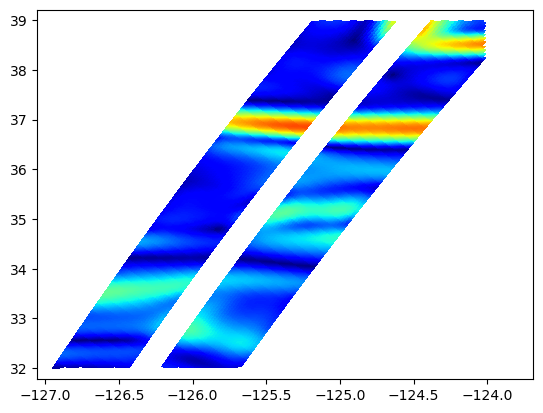

In [43]:
plt.pcolor(da_026.longitude,da_026.latitude,da_026_filt.ut_g[40],vmin = 0, vmax = .4, cmap ='jet')

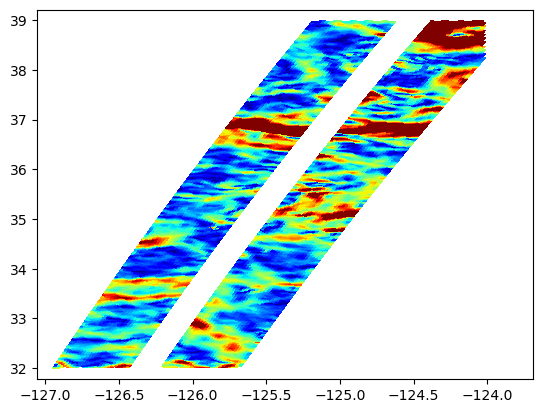

In [44]:
plt.pcolor(da_026.longitude,da_026.latitude,da_026.ut_g[40],vmin = 0, vmax = .4, cmap ='jet')

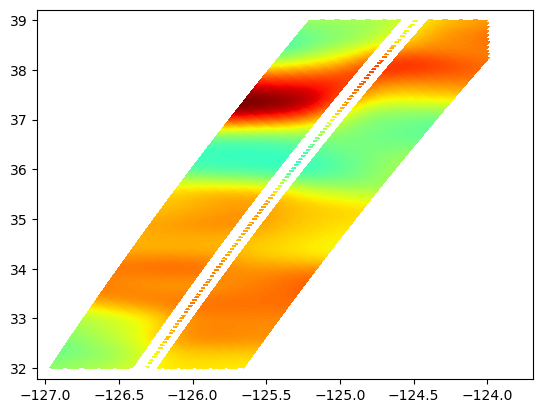

In [45]:
plt.pcolor(da_026.longitude,da_026.latitude,filtered_026[80] ,vmin = -0.15, vmax = .15, cmap ='jet')

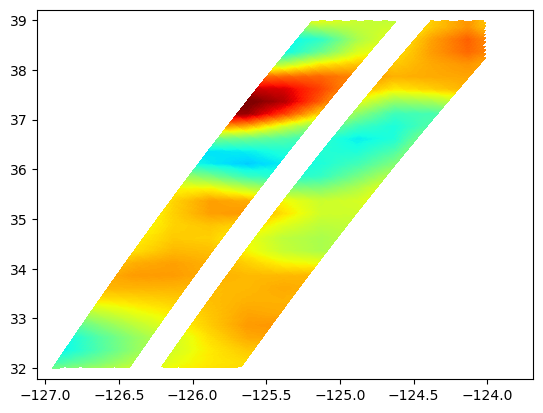

In [46]:
plt.pcolor(da_026.longitude,da_026.latitude,nc_avi_026.sla[80] ,vmin = -0.15, vmax = .15, cmap ='jet')

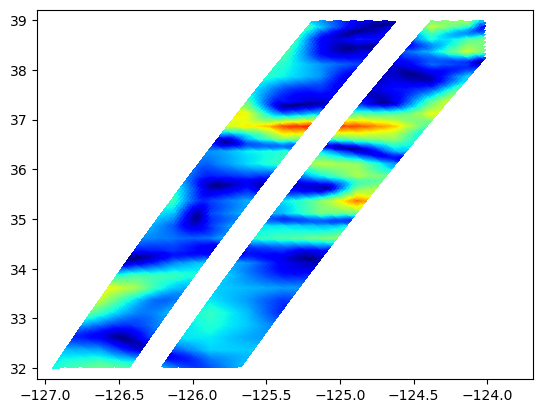

In [47]:
plt.pcolor(da_026.longitude,da_026.latitude,nc_avi_026.utgosa[40],vmin = 0, vmax = .4, cmap ='jet')

## plot aviso plus swot

In [ ]:
# Common plot parameters
params_ut = {
    'vmin': 0,
    'vmax': 0.25,
    'x': 'longitude',
    'y': 'latitude',
    'xlim': (-127, -124),
    'ylim': (32, 39),
    'cmap': 'jet',
    'add_colorbar': False  # Disable individual colorbars
}

params_uv = {
    'vmin': -0.25,
    'vmax': 0.25,
    'x': 'longitude',
    'y': 'latitude',
    'xlim': (-127, -124),
    'ylim': (32, 39),
    'cmap': 'seismic_r',
    'add_colorbar': False  # Disable individual colorbars
}

xtick = ['-127','-126.5','-126', '-125.5','-125', '-124.5', '-124']
list1=[-127, -126.5, -126, -125.5,-125, -124.5, -124]
ytick = ['32','33','34','35','36','37','38','39']
list2=[32, 33, 34, 35, 36, 37, 38, 39]
tick_uv = [-.25, -.2, -.15, -.1, -.05, 0, .05, .1, .15, .2, .25]
tick_ut = [0, .05, .1, .15, .2, .25]
cb = 'm.s$^{-1}$'
font = 25; n=8
images_directory = '/home/tchonang/calval/figure/images/pass_013/swot_aviso/'
# Set the figure resolution (optional)
dpi = 300  # Set the desired dots per inch (DPI)
label_fontsize = 14
tick_fontsize = 12
title_fontsize = 16

# Loop through each time step and plot for both datasets
for it, t in enumerate(da_026_filt.time):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
    
    # SWOT Data
    # Zonal velocity
    u_plot_swot = da_026_filt.u_g.sel(time=t).plot(ax=axes[0, 0], **params_uv)
    axes[0, 0].set_title('SWOT Zonal Velocity')
    axes[0, 0].set_xticks(list1)
    axes[0, 0].set_yticks(list2)
    axes[0, 0].set_xticklabels(xtick, fontsize=label_fontsize)
    axes[0, 0].set_yticklabels(ytick, fontsize=label_fontsize)
    axes[0, 0].set_xlabel('')
    axes[0, 0].set_ylabel('')
    
    # Meridional velocity
    v_plot_swot = da_026_filt.v_g.sel(time=t).plot(ax=axes[0, 1], **params_uv)
    axes[0, 1].set_title('SWOT Meridional Velocity')
    axes[0, 1].set_xticks(list1)
    axes[0, 1].set_yticks(list2)
    axes[0, 1].set_xticklabels(xtick, fontsize=label_fontsize)
    axes[0, 1].set_yticklabels(ytick, fontsize=label_fontsize)
    axes[0, 1].set_xlabel('')
    axes[0, 1].set_ylabel('')
    
    # Total velocity
    total_plot_swot = da_026_filt.ut_g.sel(time=t).plot(ax=axes[0, 2], **params_ut)
    axes[0, 2].set_title('SWOT Total Velocity')
    axes[0, 2].set_xticks(list1)
    axes[0, 2].set_yticks(list2)
    axes[0, 2].set_xticklabels(xtick, fontsize=label_fontsize)
    axes[0, 2].set_yticklabels(ytick, fontsize=label_fontsize)
    axes[0, 2].set_xlabel('')
    axes[0, 2].set_ylabel('')
    
    # AVISO Data
    # Zonal velocity
    u_plot_aviso = nc_avi_026.ugosa.sel(time=t).plot(ax=axes[1, 0], **params_uv)
    axes[1, 0].set_title('AVISO Zonal Velocity')
    axes[1, 0].set_xticks(list1)
    axes[1, 0].set_yticks(list2)
    axes[1, 0].set_xticklabels(xtick, fontsize=label_fontsize)
    axes[1, 0].set_yticklabels(ytick, fontsize=label_fontsize)
    axes[1, 0].set_xlabel('')
    axes[1, 0].set_ylabel('')
    
    # Meridional velocity
    v_plot_aviso = nc_avi_026.vgosa.sel(time=t).plot(ax=axes[1, 1], **params_uv)
    axes[1, 1].set_title('AVISO Meridional Velocity')
    axes[1, 1].set_xticks(list1)
    axes[1, 1].set_yticks(list2)
    axes[1, 1].set_xticklabels(xtick, fontsize=label_fontsize)
    axes[1, 1].set_yticklabels(ytick, fontsize=label_fontsize)
    axes[1, 1].set_xlabel('')
    axes[1, 1].set_ylabel('')
    
    # Total velocity
    total_plot_aviso = nc_avi_026.utgosa.sel(time=t).plot(ax=axes[1, 2], **params_ut)
    axes[1, 2].set_title('AVISO Total Velocity')
    axes[1, 2].set_xticks(list1)
    axes[1, 2].set_yticks(list2)
    axes[1, 2].set_xticklabels(xtick, fontsize=label_fontsize)
    axes[1, 2].set_yticklabels(ytick, fontsize=label_fontsize)
    axes[1, 2].set_xlabel('')
    axes[1, 2].set_ylabel('')
    
    # Create colorbar axes
    cbar_ax_u_v = fig.add_axes([0.05, 0.07, 0.6, 0.02])  # [left, bottom, width, height]
    cbar_ax_total = fig.add_axes([0.75, 0.07, 0.2, 0.02])  # [left, bottom, width, height]
    
    # Add colorbars
    cbar_u_v = ColorbarBase(cbar_ax_u_v, cmap='seismic', norm=u_plot_swot.norm, orientation='horizontal', ticks=tick_uv, extend='both')
    cbar_u_v.set_label(cb, fontsize=label_fontsize)
    cbar_u_v.ax.tick_params(labelsize=tick_fontsize)
    
    cbar_total = ColorbarBase(cbar_ax_total, cmap='jet', norm=total_plot_swot.norm, orientation='horizontal', ticks=tick_ut, extend='max')
    cbar_total.set_label(cb, fontsize=label_fontsize)
    cbar_total.ax.tick_params(labelsize=tick_fontsize)
    
    # Set the main title
    fig.suptitle(f"Velocity Components for SWOT and AVISO at Time = {t.values}", fontsize=title_fontsize, y=0.94)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    
    # Save and show the plot
    plt.savefig(images_directory + "velocity_components_swot_100km_filter_aviso_%02d.png" % it,
                transparent=False, bbox_inches='tight', dpi=dpi)
    plt.show()

In [53]:
images_directory

'/home/tchonang/calval/figure/images/pass_026/swot_aviso/'

In [50]:
# Output video file path
output_video_path = images_directory + "velocity_components_swot_100km_filter_aviso_20230329_20230707_pass_023.mp4"

# Get a list of image files in the directory
image_files = sorted([file for file in os.listdir(images_directory) if file.endswith(".png")])

# Create a writer object to save the video
writer = imageio.get_writer(output_video_path, fps=2)  # Set the desired frames per second (fps)

# Iterate through the image files and add them to the video
for image_file in image_files:
    image_path = os.path.join(images_directory, image_file)
    image = imageio.imread(image_path)
    writer.append_data(image)

# Close the writer to finalize the video
writer.close()
#### Display the video using Video
# Video(output_video_path, embed=True, mimetype='video/mp4')


/tmp/ipykernel_15220/735665877.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (5369, 3343) to (5376, 3344) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvideo @ 0x7311500] Stream #0: not enough frames to estimate rate; consider increasing probesize
[swscaler @ 0x732c300] Warning: data is not aligned! This can lead to a speed loss


## plot of SSH

In [ ]:
# Loop through each time step and plot

# Common plot parameters
params = {
    'vmin': -0.15,
    'vmax': 0.15,
    'x': 'longitude',
    'y': 'latitude',
    'xlim': (-127, -124),
    'ylim': (32, 39),
    'cmap': plt.cm.RdBu_r,
    'add_colorbar': False  # Disable individual colorbars
}

# cmap = plt.cm.RdBu_r
xtick = ['-127','-126.5','-126', '-125.5','-125', '-124.5', '-124']
list1=[-127, -126.5, -126, -125.5,-125, -124.5, -124]
ytick = ['32','33','34','35','36','37','38','39']
list2=[32, 33, 34, 35, 36, 37,38, 39]
tick = [-.15,-.1,-.05,0,.05,.1,.15]
cb = 'm'
font = 25; n=8
images_directory = '/home/tchonang/calval/figure/images/pass_013/SSH/'
# Set the figure resolution (optional)
dpi = 300  # Set the desired dots per inch (DPI)
label_fontsize = 14
tick_fontsize = 12
title_fontsize = 16

for it,t in enumerate(da_026.time):
    fig, axes = plt.subplots(1, 3, figsize=(18, 7), sharey=True)
    
    # Zonal velocity
    u_plot = da_026.SSH.sel(time=t).plot(ax=axes[0], **params)
    axes[0].set_title('SLA: SWOT',fontsize=label_fontsize)
    axes[0].set_xticks(list1, xtick)
    axes[0].set_yticks(list2)
    axes[0].set_xticklabels(xtick,fontsize=label_fontsize)
    axes[0].set_yticklabels(ytick,fontsize=label_fontsize)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('')
    
    # Meridional velocity
    u_plot = da_026_filt.SSH.sel(time=t).plot(ax=axes[1], **params)
    axes[1].set_title('SLA 100km filtered: SWOT',fontsize=label_fontsize)
    axes[1].set_xticks(list1)
    axes[1].set_yticks(list2)
    axes[1].set_xticklabels(xtick,fontsize=label_fontsize)
    axes[1].set_yticklabels(ytick,fontsize=label_fontsize)
    axes[1].set_xlabel('')
    axes[1].set_ylabel('')
    
    # Total velocity
    total_plot = nc_avi_026.sla.sel(time=t).plot(ax=axes[2], **params)
    axes[2].set_title('SLA: AVISO',fontsize=label_fontsize)
    axes[2].set_xticks(list1)
    axes[2].set_yticks(list2)
    axes[2].set_xticklabels(xtick,fontsize=label_fontsize)
    axes[2].set_yticklabels(ytick,fontsize=label_fontsize)
    axes[2].set_xlabel('')
    axes[2].set_ylabel('')
    
    # Add colorbars
    cbar_ax = fig.add_axes([1, 0.13, 0.015, 0.75])
    cbar = fig.colorbar(u_plot, cax=cbar_ax, cmap=plt.cm.RdBu_r, ticks = tick,
                        extend = 'both')
    cbar.ax.tick_params(labelsize=font)
    cbar.ax.set_title(cb,fontsize=font)
    
    
    # Set the main title
    fig.suptitle(f"Time = {t.values}", fontsize=title_fontsize, y=0.92, color='blue')
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Show the plot
    plt.savefig(images_directory+"SSH_SWOT_AVISO_%02d.png" % it,
                 transparent = False, bbox_inches = 'tight', dpi = 300)
    plt.show()

In [63]:
# Output video file path
output_video_path = images_directory + "ssh_swot_100km_filter_aviso_20230329_20230707_pass_026.mp4"

# Get a list of image files in the directory
image_files = sorted([file for file in os.listdir(images_directory) if file.endswith(".png")])

# Create a writer object to save the video
writer = imageio.get_writer(output_video_path, fps=2)  # Set the desired frames per second (fps)

# Iterate through the image files and add them to the video
for image_file in image_files:
    image_path = os.path.join(images_directory, image_file)
    image = imageio.imread(image_path)
    writer.append_data(image)

# Close the writer to finalize the video
writer.close()
#### Display the video using Video
# Video(output_video_path, embed=True, mimetype='video/mp4')

/tmp/ipykernel_36861/4102167592.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (5844, 1904) to (5856, 1904) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvideo @ 0x56f3500] Stream #0: not enough frames to estimate rate; consider increasing probesize


In [51]:
directory = '/mnt/flow/swot/Matt_Analysis/CNES_L3_CalVal/version_V1_0/'
da_026.to_netcdf(directory+'SUBSET_SWOT_UV_PASS_013_OVER_CALVAL_REGION_V1.0.nc')
nc_avi_026.to_netcdf(directory+'SUBSET_AVISO_UV_PASS_013_OVER_CALVAL_REGION_V1.0.nc')

/tmp/ipykernel_15220/510480516.py:3: SerializationWarning: saving variable longitude with floating point data as an integer dtype without any _FillValue to use for NaNs
  nc_avi_026.to_netcdf(directory+'SUBSET_AVISO_UV_PASS_013_OVER_CALVAL_REGION_V1.0.nc')
/tmp/ipykernel_15220/510480516.py:3: SerializationWarning: saving variable latitude with floating point data as an integer dtype without any _FillValue to use for NaNs
  nc_avi_026.to_netcdf(directory+'SUBSET_AVISO_UV_PASS_013_OVER_CALVAL_REGION_V1.0.nc')


In [52]:
da_026_filt.to_netcdf(directory+'FILT103_SUBSET_SWOT_UV_PASS_013_OVER_CALVAL_REGION_V1.0.nc')

In [53]:
lon = nc_interp.longitude.values
lat = nc_interp.latitude.values
u_avi = np.where(np.isnan(da), np.nan, nc_interp.ugosa )
v_avi = np.where(np.isnan(da), np.nan, nc_interp.vgosa )
plt.pcolor(lon,lat,u_avi,vmin = -.25, vmax = .25, cmap ='jet')

NameError: name 'nc_interp' is not defined

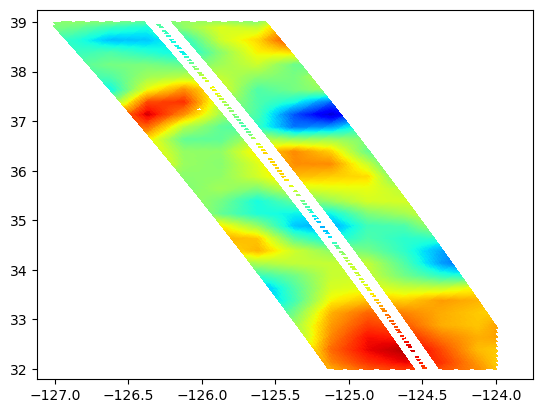

In [154]:
plt.pcolor(lon,lat,v_avi,vmin = -.25, vmax = .25, cmap ='jet')

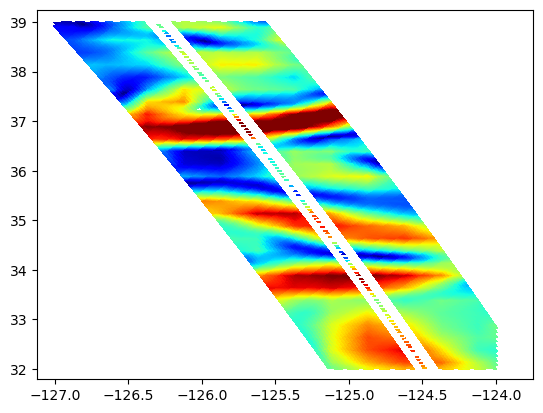

In [143]:
plt.pcolor(lon,lat,np.sqrt(u_avi**2+v_avi**2),vmin = 0, vmax = .25, cmap ='jet')

In [85]:


# # Example data loading
# # Replace this with your actual data loading method
# data = np.random.random((100, 100))  # Example data
# data[::10, ::10] = np.nan  # Introduce NaNs for testing

# Apply Hanning filter with calculated sizes for 100 km
filtered_026_100km = apply_hanning(ssh_swot_026[80,:,:], 55, 11)  # 100 km filter

/tmp/ipykernel_43546/2207619327.py:22: RuntimeWarning: invalid value encountered in divide
  filtered_data /= normalization


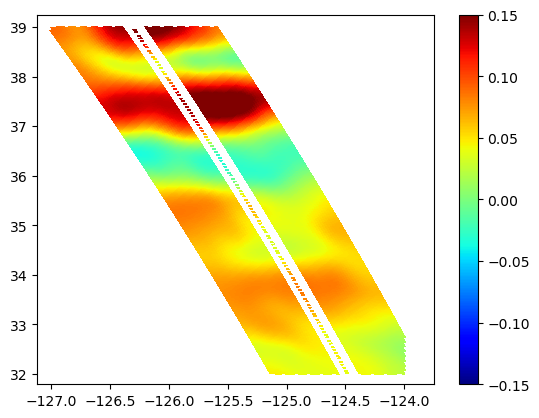

In [86]:
filtered_026_150km = np.where(np.isnan(ssh_swot_026[80,:,:]),np.nan,filtered_026_100km[:,:])
plt.pcolor(lon_026, lat_026,filtered_026_150km, vmin=-.15, vmax=.15, cmap = 'jet')
plt.colorbar()

In [87]:
filtered_100km.shape

NameError: name 'filtered_100km' is not defined

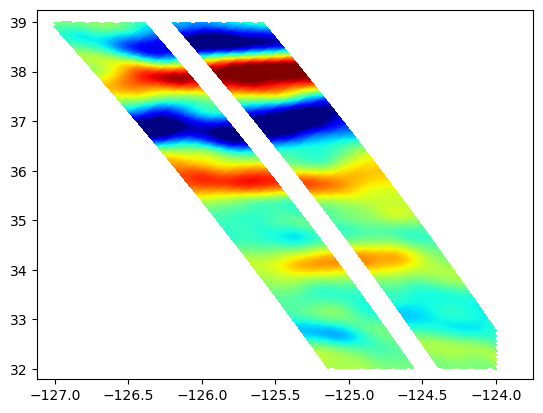

In [88]:
# ds = ds.rename({'ssha': 'SSH'})
# ds['SSH'] = xr.DataArray(filtered_150km, dims=('num_lines', 'num_pixels'), coords=ds.ssha.coords)

da = compute_geostrophic_velocities(lat_026,lon_026,filtered_026_150km)

plt.pcolor(lon_026,lat_026,da.u_g,vmin = -.25, vmax = .25, cmap ='jet')

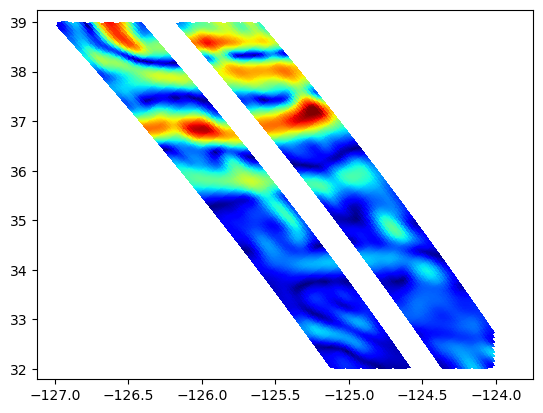

In [89]:
plt.pcolor(lon_026,lat_026,np.sqrt(da.v_g**2+da.u_g**2),vmin = 0, vmax = .4, cmap ='jet')

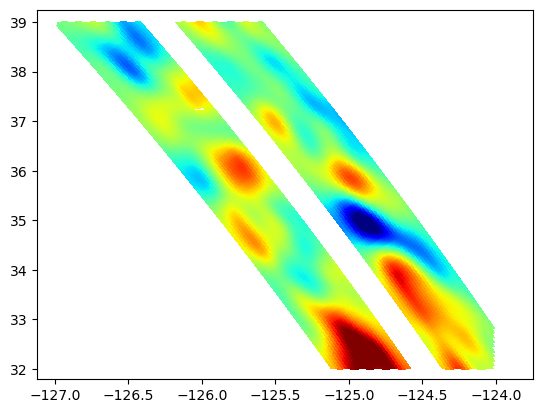

In [225]:
plt.pcolor(ds.longitude,ds.latitude,da.v_g,vmin = -.25, vmax = .25, cmap ='jet')

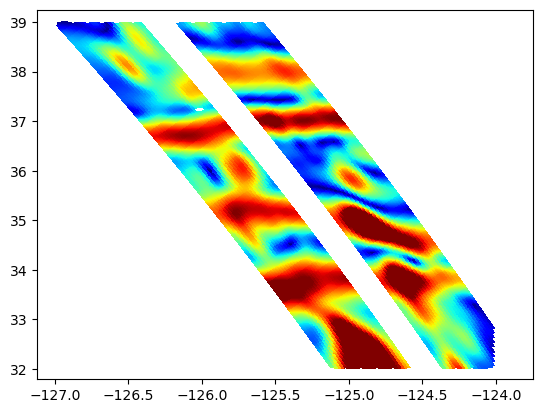

In [226]:
plt.pcolor(lon,lat,np.sqrt(da.u_g**2+da.v_g**2),vmin = 0, vmax = .2, cmap ='jet')

In [33]:
lat1_026, lon1_026, lat2_026, lon2_026 = lat_026[0,0],lon_026[0,0],lat_026[-1,0],lon_026[0,-1] 

# Example usage:
bearings_026 = compute_along_track_directions(lat_026[:,0], lat_026[:,0])
average_bearing_026 = compute_average_bearing(bearings_026)
print("Average Along-Track Direction:", average_bearing_026)
theta_026=average_bearing_026
u_geo, v_geo = rotate_coordinates(da_026.u_g.values[30,:,:], da_026.v_g.values[30,:,:], theta_026)

Average Along-Track Direction: 219.07831216146792


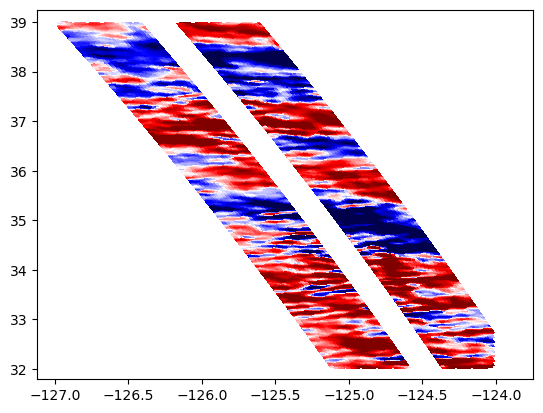

In [36]:
plt.pcolor(lon_026,lat_026,da_026.v_e.values[3,:,:],vmin = -.25, vmax = .25, cmap ='seismic_r')

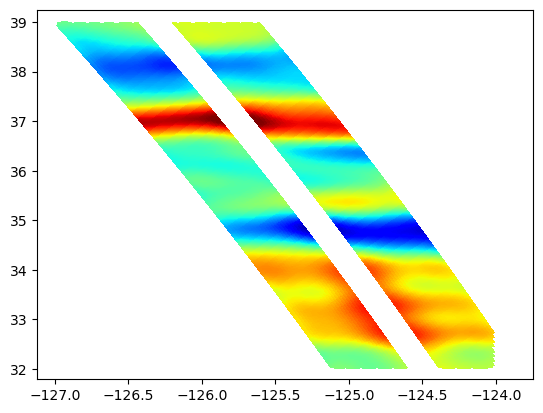

In [254]:
plt.pcolor(lon_026,lat_026,u_geo,vmin = -.2, vmax = .2, cmap ='jet')

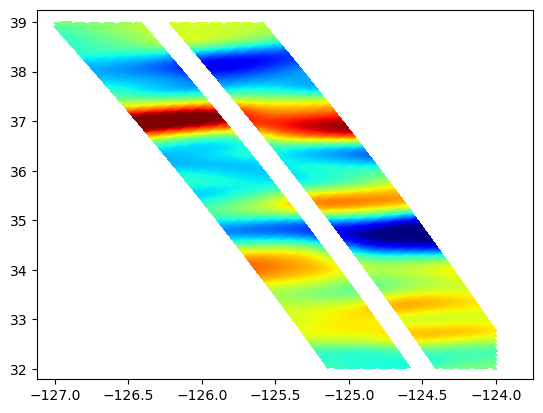

In [259]:
plt.pcolor(lon_026,lat_026,-da_026_filt.u_g.values[30,:,:],vmin = -.2, vmax = .2, cmap ='jet')

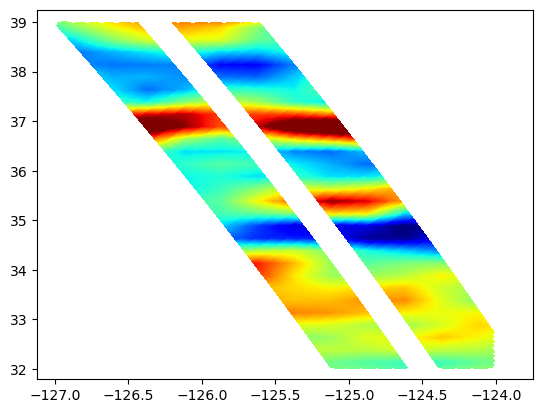

In [260]:
plt.pcolor(lon_026,lat_026,-nc_avi_026.ugosa.values[30,:,:],vmin = -.2, vmax = .2, cmap ='jet')

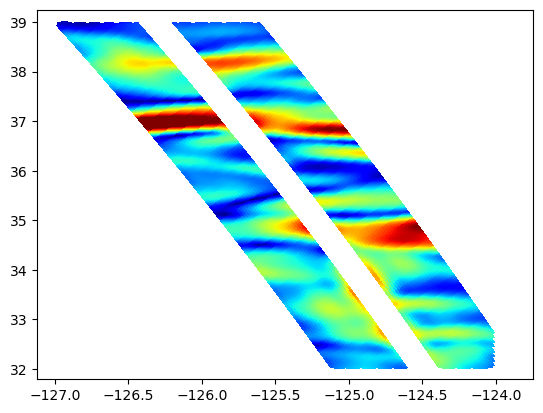

In [166]:
plt.pcolor(lon_026,lat_026,np.sqrt(u_geo**2+v_geo**2),vmin = 0, vmax = .25, cmap ='jet')

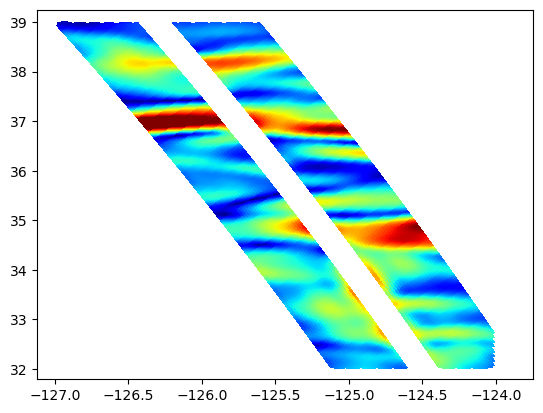

In [169]:
plt.pcolor(lon_026,lat_026,np.sqrt(da_026_filt.v_g[30,:,:]**2+da_026_filt.u_g[30,:,:]**2),vmin = 0, vmax = .25, cmap ='jet')

In [167]:
time_026[30]

numpy.datetime64('2023-04-29T14:44:14.382852864')